In [122]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import MultipleLocator
import os.path
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from qbo1d import utils
from qbo1d import adsolver
from qbo1d import emulate
from qbo1d.stochastic_forcing import WaveSpectrum

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from qbo1d.stochastic_forcing import sample_sf_cw

from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.multioutput import MultiOutputRegressor

from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
# Load the data manually
# it takes 40 seconds

t_max = 360 * 108 * 86400
nsteps = 360 * 108
nspinup = 360 * 12
ntot = int(nsteps - nspinup)

torch.set_default_dtype(torch.float64)


# scenario 0 (control)
# --------------------
solver = adsolver.ADSolver(t_max=t_max, w=3e-4)
model = WaveSpectrum(solver)
time = solver.time
z = solver.z
u = solver.solve(source_func=model)


cw = model.cw[nspinup:nsteps]
sf = model.sf[nspinup:nsteps]
u = u[nspinup:nsteps, :]

s = model.s[nspinup:nsteps, :]

s_scalar = StandardScaler()
s = s_scalar.fit_transform(s)

U = torch.hstack([u, sf.view(-1, 1), cw.view(-1, 1)])
print(f"The shape of data U is {U.shape}")


# Here U is the features and s is the label

U_train, U_test, s_train, s_test = train_test_split(U, s, test_size=0.2, random_state=42)

The shape of data U is torch.Size([34560, 75])


In [124]:
# In this step we need to extract U back to do the PCA
# in the last step, we need to pair u with sf and cw
U_ = U_train[:, :73]

In [125]:
reductor = PCA(n_components=2)
reductor.fit(U_)
reductor.explained_variance_ratio_

array([0.72150492, 0.2120714 ])

In [126]:
uuu = reductor.transform(U_)

In [127]:
U_train_reducted = reductor.transform(U_)
U_train_ = torch.hstack([torch.tensor(reductor.transform(U_)), U_train[:, 73:]])
U_test_ = torch.hstack([torch.tensor(reductor.transform(U_test[:, :73])), U_test[:, 73:]])

In [128]:
s_train_35 = s_train[:, 35]
s_test_35 = s_test[:, 35]

In [132]:
svr = SVR(kernel='rbf', gamma='auto', epsilon=.001)
svr.fit(U_train_, s_train_35)

SVR(epsilon=0.001, gamma='auto')

In [133]:
svr.score(U_test_, s_test_35)

0.18179118559024177

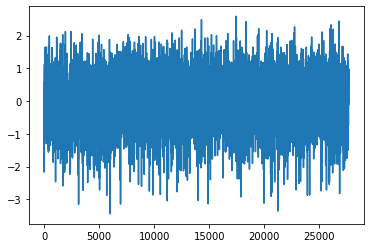

In [131]:
plt.plot(svr.predict(U_train_))